<a href="https://colab.research.google.com/github/pranathadoddy/gender-prediction/blob/main/resnet34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preparation

In [67]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from PIL import Image

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
dfGender = pd.read_csv('/content/list_attribute.txt', sep="\s+", skiprows=1, usecols=['Male'])
dfGender.loc[dfGender['Male'] == -1, 'Male'] = 0
dfGender.head()

,Male
000001.jpg,0
000002.jpg,0
000003.jpg,1
000004.jpg,0
000005.jpg,0


In [70]:
filenames = os.listdir("/content/drive/MyDrive/Images/")
dfGender = dfGender[dfGender.index.isin(filenames)]


dfGender.head()

,Male
000051.jpg,1
000052.jpg,1
000065.jpg,1
000166.jpg,1
000198.jpg,0


(218, 178, 3)
(218, 178, 3)
(218, 178, 3)


Text(0.5, 1.0, '(218, 178, 3)')

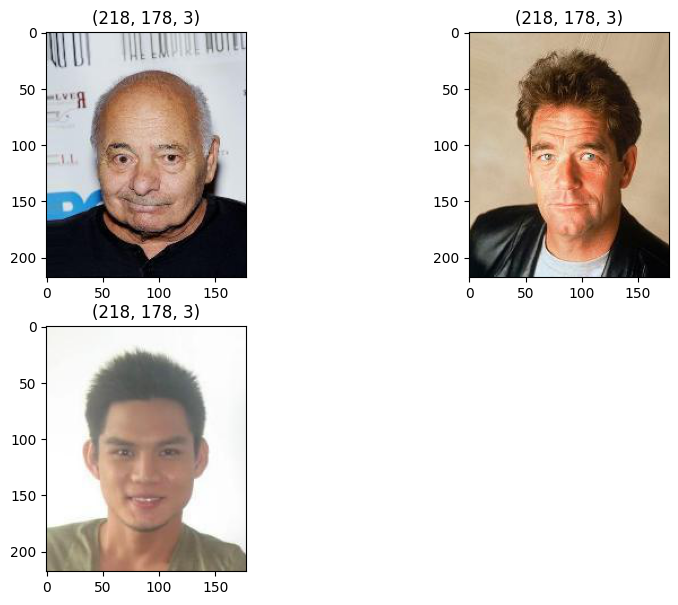

In [71]:
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(2, 2, 1)

img1 = Image.open('/content/drive/MyDrive/Images/000051.jpg')
print(np.asarray(img1, dtype=np.uint8).shape)
plt.imshow(img1);
plt.title(np.asarray(img1, dtype=np.uint8).shape)

fig.add_subplot(2, 2, 2)

img2 = Image.open('/content/drive/MyDrive/Images/000052.jpg')
print(np.asarray(img2, dtype=np.uint8).shape)
plt.imshow(img2);
plt.title(np.asarray(img2, dtype=np.uint8).shape)

fig.add_subplot(2, 2, 3)

img3 = Image.open('/content/drive/MyDrive/Images/000065.jpg')
print(np.asarray(img3, dtype=np.uint8).shape)
plt.imshow(img3);
plt.title(np.asarray(img3, dtype=np.uint8).shape)

In [72]:
dfPartition = pd.read_csv('list_eval_partition.txt', sep="\s+", skiprows=0, header=None)
dfPartition.columns = ['Filename', 'Partition']
dfPartition = dfPartition.set_index('Filename')

dfPartition = dfPartition[dfPartition.index.isin(filenames)]
dfPartition.head()

,Partition
Filename,
000051.jpg,0
000052.jpg,0
000065.jpg,0
000166.jpg,0
000198.jpg,0


In [73]:
dfGenderPartition = dfGender.merge(dfPartition, left_index=True, right_index=True)
dfGenderPartition.head()

,Male,Partition
000051.jpg,1,0
000052.jpg,1,0
000065.jpg,1,0
000166.jpg,1,0
000198.jpg,0,0


In [74]:
dfGenderPartition.loc[dfGenderPartition['Partition'] == 0].to_csv('gender_train.csv')
dfGenderPartition.loc[dfGenderPartition['Partition'] == 1].to_csv('gender_valid.csv')
dfGenderPartition.loc[dfGenderPartition['Partition'] == 2].to_csv('gender_test.csv')

# Data Loader

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets

class ImageGenderDataset(Dataset):

    def __init__(self, csv_path, img_dir, transform=None):

        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [76]:
BATCH_SIZE = 100

train_dataset = ImageGenderDataset(csv_path='gender_train.csv',
                              img_dir='/content/drive/MyDrive/Images/')

valid_dataset = ImageGenderDataset(csv_path='gender_valid.csv',
                              img_dir='/content/drive/MyDrive/Images/')

test_dataset = ImageGenderDataset(csv_path='gender_test.csv',
                             img_dir='/content/drive/MyDrive/Images/')


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


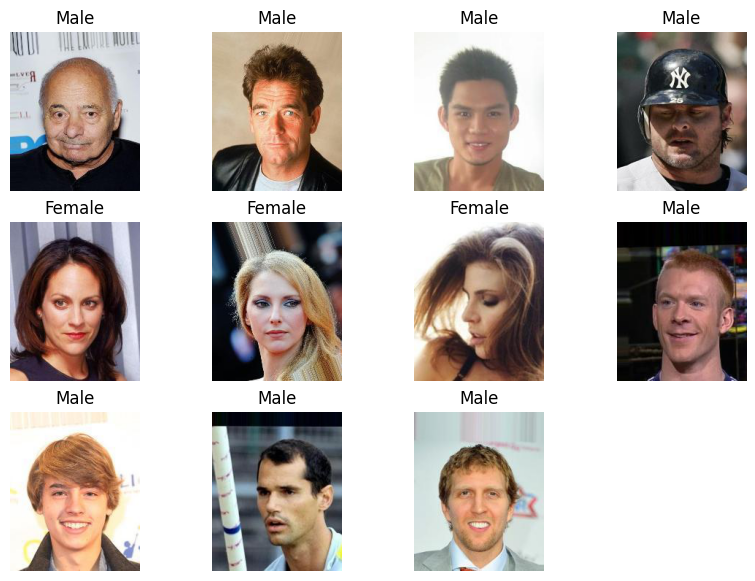

In [78]:
fig = plt.figure(figsize=(10, 7))

for i, train in enumerate(train_dataset):

    fig.add_subplot(3, 4, i + 1)

    gender =  "Male" if train[1] == 1 else "Female"
    plt.title(gender)
    plt.axis('off')
    plt.imshow(train[0])

    if i == 10:
        plt.show()
        break